#**Predicting Patient Readmissions in Hospitals: A Machine Learning Approach**


---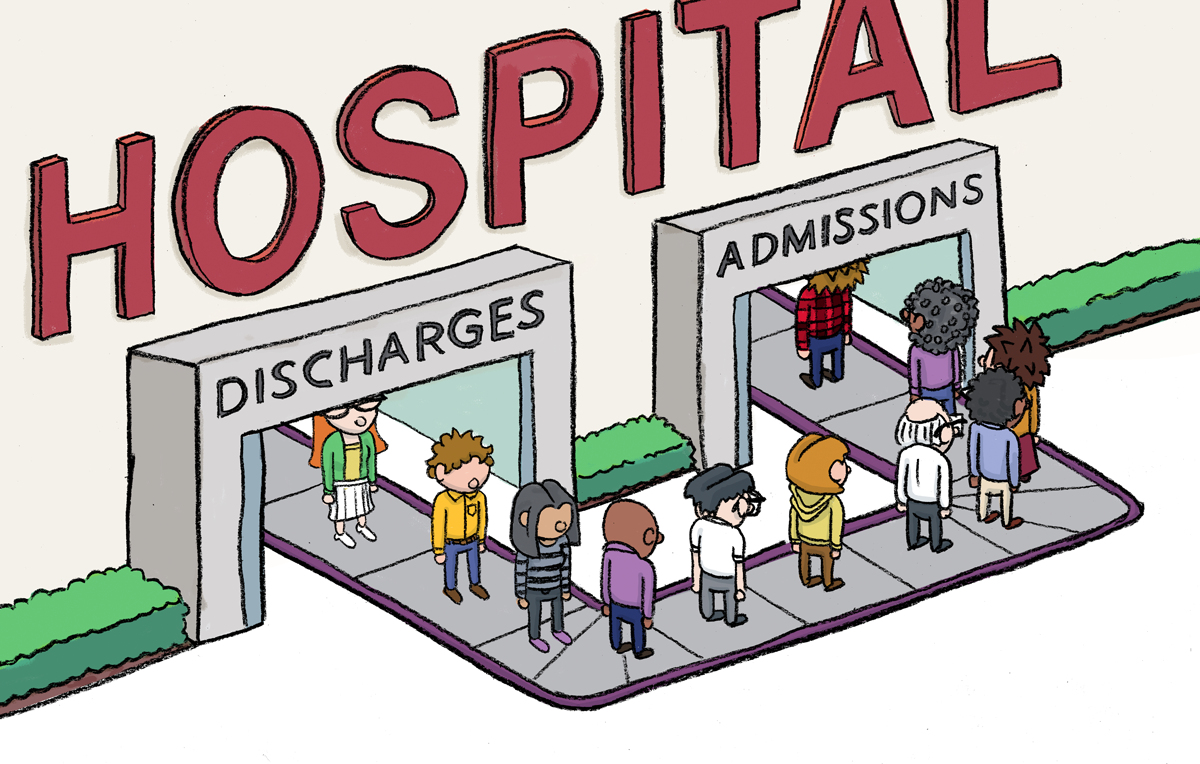



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

import pandas as pd

# Read the diabetic_data.csv file
file_path = '/content/drive/MyDrive/diabetic_data.csv'
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries needed,
import IPython
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statistics import mode

import seaborn as sns

In [ ]:
#Loading the data using pandas,

#diabetic_data = pd.read_csv("diabetic_data.csv")

print(df.shape)

# Exploring the data further
#print(diabetic_data.info())
#print(diabetic_data.describe())


(101766, 50)


### To obtain occurrences for each unique value in the 'gender' column of the DataFrame df. Here's the code snippet:

In [ ]:
gender_counts = df['gender'].value_counts()
print('Gender Statistics:')
for gender, count in gender_counts.items():
    print(f'{gender}: {count}')


Gender Statistics:
Female: 54708
Male: 47055
Unknown/Invalid: 3


### Printing the column names along with their corresponding count of missing values represented as '?' .

In [ ]:
from tabulate import tabulate
missing_columns = df.columns[df.isin(['?']).any()]
missing_counts = []
print('Columns with missing values:')
for column in missing_columns:
    missing_count = df[column][df[column] == '?'].count()
    missing_counts.append([column, missing_count])
missing_counts.sort(key=lambda x: x[1], reverse=True)
print(tabulate(missing_counts, headers=["Column", "Missing Count"], tablefmt="fancy_grid"))

Columns with missing values:
╒═══════════════════╤═════════════════╕
│ Column            │   Missing Count │
╞═══════════════════╪═════════════════╡
│ weight            │           98569 │
├───────────────────┼─────────────────┤
│ medical_specialty │           49949 │
├───────────────────┼─────────────────┤
│ payer_code        │           40256 │
├───────────────────┼─────────────────┤
│ race              │            2273 │
├───────────────────┼─────────────────┤
│ diag_3            │            1423 │
├───────────────────┼─────────────────┤
│ diag_2            │             358 │
├───────────────────┼─────────────────┤
│ diag_1            │              21 │
╘═══════════════════╧═════════════════╛


### Now we will remove the columns 'weight', 'medical_specialty', and 'payer_code' from your dataset df due to their high number of missing values,

In [ ]:
columns_to_remove = ['weight', 'medical_specialty', 'payer_code']
df.drop(columns=columns_to_remove, inplace=True)

In [ ]:
print(df.shape)

(101766, 47)


### This code drops the rows that have missing values represented as '?' in the specified columns, as well as the rows with specific conditions (e.g., 'discharge_disposition_id' equal to 11 or 'gender' equal to 'Unknown/Invalid'), and retains the rows with valid data in those columns.

The number 11 in the 'discharge_disposition_id' column often represents a specific discharge status, such as "Expired" or "Death." Removing these rows might be necessary depending on the context of the analysis.

In [ ]:
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(df['diag_1'][df['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_2'][df['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_3'][df['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['race'][df['race'] == '?'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

In [ ]:
print(df.shape)

(96446, 47)


As we can see from below code, the values and their respective counts in the 'citoglipton' and 'examide' columns of the DataFrame.

For the 'citoglipton' column:

There is a single unique value, which is 'No'.
The count of occurrences for this value is 96446.
For the 'examide' column:

There is also a single unique value, which is 'No'.
The count of occurrences for this value is also 96446.
In both cases, it seems that the 'citoglipton' and 'examide' columns predominantly contain the value 'No', as indicated by the count of 96446 for each column.

### Essentially, these two variables do not offer meaningful or differentiating information for predicting readmission. As a result, we have made the decision to remove them from the analysis.

In [ ]:
print("Values in 'citoglipton' column:")
print(df['citoglipton'].value_counts())

print("\nValues in 'examide' column:")
print(df['examide'].value_counts())

Values in 'citoglipton' column:
No    96446
Name: citoglipton, dtype: int64

Values in 'examide' column:
No    96446
Name: examide, dtype: int64


In [ ]:
df = df.drop(['citoglipton', 'examide'], axis = 1)

In [ ]:
print(df.shape)

(96446, 45)


## **Feature Engineering**

##Feature engineering is a critical step in the machine learning pipeline. It involves creating new features from the existing data to improve model performance. In the context of the "Diabetes 130-US hospitals for years 1999-2008 Data Set", here are a few ideas for feature engineering:

1. As you are aware, I have utilized the "Diabetes 130-US hospitals for years 1999-2008 Data Set" to analyze service utilization. The dataset includes variables representing the number of inpatient admissions, emergency room visits, and outpatient visits a patient has had within the previous year. These variables serve as crude measures of the extent to which a person has utilized hospital/clinic services in the past year. To assess the effectiveness of different approaches, we combined these three variables into a new variable called service utilization (refer to the figure below). Although we did not apply any specific weighting to these components of service utilization, our aim was to experiment with a simple approach during this stage.

In [ ]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [ ]:
print(df.shape)

(96446, 46)


This code creating a temporary feature for each medication column in the dataframe. These temporary features are binary, with a value of 1 if the original medication feature was either "Up" or "Down", and a value of 0 if the original medication feature was either "No" or "Steady". In essence, it is encoding whether the dosage of the medication was changed during the hospital stay.

Then, the script is creating a new feature 'numchange' that sums up the values of these temporary features. So, for each patient, 'numchange' will indicate the number of medications that had their dosage changed during the hospital stay.


Feature engineering is a critical step in the machine learning pipeline. It involves creating new features from the existing data to improve model performance. In the context of the "Diabetes 130-US hospitals for years 1999-2008 Data Set", here are a few ideas for feature engineering:

1. Binary Encoding of Medication Change: Similar to the previous Python code you provided, you can create a binary feature for each medication that indicates whether the dosage of the medication was changed during the hospital stay.

##Great! It sounds like we want to create binary features for each medication indicating whether the dosage was changed during the patient's hospital stay. This will allow you to analyze the impact of changes in specific medications on readmission. Here is how you do it:

With this code, we will now have additional binary columns in our dataframe for each medication. Each new column indicates whether the dosage of the respective medication was increased ('Up') or decreased ('Down') during the hospital stay. A value of 1 indicates a change in dosage, while 0 indicates no change. These new features can help us examine how dosage changes in specific medications may affect the likelihood of patient readmission.

In [ ]:
# List of medication columns
medication_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

# Create a binary feature for each medication indicating whether the dosage was changed
for col in medication_columns:
    colname = str(col) + '_changed'
    df[colname] = df[col].apply(lambda x: 1 if (x == 'Up' or x == 'Down') else 0)


To count the values for the newly created binary columns, we can loop through these columns and print the count of '1' and '0' values for each. Here's how you can do it:

In [ ]:
from tabulate import tabulate

# List of medication columns
medication_columns_changed = [col + '_changed' for col in medication_columns]

# Create a dictionary to store the value counts for each column
value_counts_dict = {}

# Calculate value counts for each medication_changed column
for col in medication_columns_changed:
    value_counts_dict[col] = df[col].value_counts()

# Create a DataFrame from the value counts dictionary
value_counts_df = pd.DataFrame(value_counts_dict)

# Transpose the DataFrame and assign a name to the index
transposed_df = value_counts_df.transpose()
transposed_df = transposed_df.rename_axis('Medication Columns Changed')

# Print the transposed DataFrame as a table
print(tabulate(transposed_df, headers='keys', tablefmt='psql'))

+----------------------------------+-------+-------+
| Medication Columns Changed       |     0 |     1 |
|----------------------------------+-------+-------|
| metformin_changed                | 94878 |  1568 |
| repaglinide_changed              | 96295 |   151 |
| nateglinide_changed              | 96412 |    34 |
| chlorpropamide_changed           | 96439 |     7 |
| glimepiride_changed              | 95951 |   495 |
| glipizide_changed                | 95162 |  1284 |
| glyburide_changed                | 95126 |  1320 |
| pioglitazone_changed             | 96109 |   337 |
| rosiglitazone_changed            | 96194 |   252 |
| acarbose_changed                 | 96433 |    13 |
| miglitol_changed                 | 96440 |     6 |
| insulin_changed                  | 74121 | 22325 |
| glyburide-metformin_changed      | 96437 |     9 |
| tolazamide_changed               | 96445 |     1 |
| metformin-pioglitazone_changed   | 96446 |   nan |
| metformin-rosiglitazone_changed  | 96446 |  

**For the above code, it does not add any new columns or rows to your original DataFrame df.**

What this code does is to create a new separate DataFrame **value_counts_df** using the dictionary value_counts_dict which stores the value counts for each column in **medication_columns_changed**. This new DataFrame is not part of our original DataFrame df.

In [ ]:
print("Data shape:", df.shape)

Data shape: (96446, 67)


## Re-encoding admission type, discharge type and admission source into fewer categories

 To perform the re-encoding, we can use the following code. This code assumes that the 'admission_type_id', 'discharge_disposition_id', and 'admission_source_id' columns exist in our dataframe 'df' and contain the correct values as per the Diabetes dataset.

In [ ]:
# Recategorizing 'admission_type_id'
df['admission_type_id'] = df['admission_type_id'].map({
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    5: 'Not Available',
    6: 'NULL',
    7: 'Trauma Center',
    8: 'Not Mapped'
})

# Combine similar categories
df['admission_type_id'] = df['admission_type_id'].replace({
    'Emergency': 'Emergency/Urgent',
    'Urgent': 'Emergency/Urgent',
    'Elective': 'Elective',
    'Newborn': 'Other/Not Specified',
    'Not Available': 'Other/Not Specified',
    'NULL': 'Other/Not Specified',
    'Trauma Center': 'Other/Not Specified',
    'Not Mapped': 'Other/Not Specified'
})

# Recategorizing 'discharge_disposition_id'
df['discharge_disposition_id'] = df['discharge_disposition_id'].map({
    1: 'Discharged to home',
    2: 'Transferred to another medical facility',
    3: 'Transferred to SNF',
    4: 'Transferred to ICF',
    5: 'Transferred to another type of inpatient care institution',
    6: 'Discharged to home with home health service',
    7: 'Left AMA',
    8: 'Transferred to home under care of Home IV provider',
    9: 'Admitted as an inpatient to this hospital',
    10: 'Neonate discharged to another hospital for neonatal aftercare',
    11: 'Expired',
    12: 'Still patient or expected to return for outpatient services',
    13: 'Hospice / home',
    14: 'Hospice / medical facility',
    15: 'Transferred within this institution',
    16: 'Transferred to federal health care facility',
    17: 'Transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
    18: 'Transferred/referred to a long term care hospital',
    19: 'Expired at home. Medicaid only, hospice',
    20: 'Expired in a medical facility. Medicaid only, hospice',
    21: 'Expired, place unknown. Medicaid only, hospice',
    22: 'Discharged/transferred to another rehab fac including rehab units of a hospital',
    23: 'Discharged/transferred to a long term care hospital',
    24: 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare',
    25: 'Not Mapped',
    26: 'Unknown/Invalid',
    30: 'NULL',
    27: 'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere',
    28: 'Discharged/transferred to a federal health care facility',
    29: 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital'
})

# Combine similar categories
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({
    'Discharged to home': 'Discharged to home',
    'Transferred to another medical facility': 'Transferred to another facility',
    'Home with home health service': 'Home with home health service',
    'Left AMA': 'Left AMA',
    'Admitted as inpatient to this hospital': 'Admitted as inpatient to this hospital',
    'Neonate discharged to another hospital': 'Neonate discharged',
    'Expired': 'Expired',
    'Still patient or expected to return for outpatient services': 'Outpatient services',
    'Hospice / home': 'Hospice',
    'Hospice / medical facility': 'Hospice',
    'Transferred within this institution': 'Transferred within this institution',
    'Transferred to another health care institution': 'Transferred to another health care institution',
    'NULL': 'Other/Not Specified',
    'Not Mapped': 'Other/Not Specified',
    'Unknown/Invalid': 'Other/Not Specified',
})


# Recategorizing 'admission_source_id'
df['admission_source_id'] = df['admission_source_id'].map({
    1: 'Physician Referral',
    2: 'Clinic Referral',
    3: 'HMO Referral',
    4: 'Transfer from a hospital',
    5: 'Transfer from a Skilled Nursing Facility (SNF)',
    6: 'Transfer from another health care facility',
    7: 'Emergency Room',
    8: 'Court/Law Enforcement',
    9: 'Not Available',
    10: 'Transfer from critial access hospital',
    11: 'Normal Delivery',
    12: 'Premature Delivery',
    13: 'Sick Baby',
    14: 'Extramural Birth',
    15: 'Not Available',
    16: 'Not Listed',
    17: 'NULL',
    18: 'Transfer From Another Home Health Agency',
    19: 'Readmission to Same Home Health Agency',
    20: 'Not Mapped',
    21: 'Unknown/Invalid',
    22: 'Transfer from hospital inpt/same fac reslt in a sep claim',
    23: 'Born inside this hospital',
    24: 'Born outside this hospital',
    25: 'Transfer from Ambulatory Surgery Center',
    26: 'Transfer from Hospice'
})

# Combine similar categories
df['admission_source_id'] = df['admission_source_id'].replace({
    'Physician Referral': 'Referral',
    'Clinic Referral': 'Referral',
    'HMO Referral': 'Referral',
    'Transfer from a hospital': 'Transfer',
    'Transfer from a Skilled Nursing Facility (SNF)': 'Transfer',
    'Transfer from another health care facility': 'Transfer',
    'Emergency Room': 'Emergency Room',
    'Court/Law Enforcement': 'Other',
    'Not Available': 'Other',
    'Transfer from critial access hospital': 'Transfer',
    'Normal Delivery': 'Delivery',
    'Premature Delivery': 'Delivery',
    'Sick Baby': 'Delivery',
    'Extramural Birth': 'Delivery',
    'Not Listed': 'Other',
    'NULL': 'Other',
    'Transfer From Another Home Health Agency': 'Transfer',
    'Readmission to Same Home Health Agency': 'Other',
    'Not Mapped': 'Other',
    'Unknown/Invalid': 'Other',
    'Transfer from hospital inpt/same fac reslt in a sep claim': 'Transfer',
    'Born inside this hospital': 'Delivery',
    'Born outside this hospital': 'Delivery',
    'Transfer from Ambulatory Surgery Center': 'Transfer',
    'Transfer from Hospice': 'Transfer',
})


If we want to view the unique values in the newly re-encoded columns, we can do this:


In [ ]:
# For 'admission_type_id'
admission_type_counts = pd.DataFrame(df['admission_type_id'].value_counts().reset_index()).rename(columns={'index': 'admission_type_id', 'admission_type_id': 'count'})
display(admission_type_counts)

# For 'discharge_disposition_id'
discharge_disposition_counts = pd.DataFrame(df['discharge_disposition_id'].value_counts().reset_index()).rename(columns={'index': 'discharge_disposition_id', 'discharge_disposition_id': 'count'})
display(discharge_disposition_counts)

# For 'admission_source_id'
admission_source_counts = pd.DataFrame(df['admission_source_id'].value_counts().reset_index()).rename(columns={'index': 'admission_source_id', 'admission_source_id': 'count'})
display(admission_source_counts)


,admission_type_id,count
0,Emergency/Urgent,68397
1,Elective,18070
2,Other/Not Specified,9979


,discharge_disposition_id,count
0,Discharged to home,57609
1,Transferred to SNF,13564
2,Discharged to home with home health service,12626
3,Transferred/referred to a long term care hospital,3624
4,Transferred to another facility,2049
5,Discharged/transferred to another rehab fac in...,1970
6,Transferred to another type of inpatient care ...,1127
7,Other/Not Specified,941
8,Hospice,764
9,Transferred to ICF,756


,admission_source_id,count
0,Emergency Room,54847
1,Referral,29308
2,Other,6690
3,Transfer,5596
4,Delivery,5


##Encoding some variables:

## 23 drug columns of your dataset.

For each column, the following lines replace specific string values with the numeric value 1:
'**No**' is replaced with 0.
**'Steady', 'Up', and 'Down'** are all replaced with 1.

##Categorical variables

Such as "medication change," "gender," and "diabetesMed" were encoded using binary values for effective distinction. For "gender" "Male" was encoded as 1 and "Female" as 0 for gender, while the presence of a race category was represented by 1 and its absence by 0.

In [ ]:
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)
# keys is the same as before
for col in medication_columns:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

#We also reduced both A1C test result and Glucose serum test result into categories of Normal, Abnormal and Not tested.

The ordinal encoding, we might want to give ordered values to the categories. we can assign 'None' to 0, 'Norm' to 1, '>7' or '>200' to 2, '>8' or '>300' to 3, indicating the severity in the test result.

In [ ]:
import pandas as pd

# get our data from DataFrame df

def ordinal_encode(df, column, mapping):
    df[column] = df[column].map(mapping)

# Define the ordinal mapping for A1Cresult
A1C_mapping = {'None': 0, 'Norm': 1, '>7': 2, '>8': 3}

# Define the ordinal mapping for max_glu_serum
glu_mapping = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}

# Perform the encoding
ordinal_encode(df, 'A1Cresult', A1C_mapping)
ordinal_encode(df, 'max_glu_serum', glu_mapping)


In [ ]:
# print the unique (distinct) values in the 'A1Cresult' and 'max_glu_serum' columns,

print("Unique values in 'A1Cresult':", df['A1Cresult'].unique())
print("Unique values in 'max_glu_serum':", df['max_glu_serum'].unique())


Unique values in 'A1Cresult': [0 2 3 1]
Unique values in 'max_glu_serum': [0 3 1 2]


Given that the 'age' column is divided into 10-year increments (e.g., '[0-10)', '[10-20)', ..., '[90-100)'), one way to convert these age ranges to a numerical form for our machine learning model is to take the midpoint of each range as a representative value.

For example, we could convert '[0-10)' to 5, '[10-20)' to 15, and so on. This approach represents the age category as a single number and allows our model to capture the general trend of increasing age, though it necessarily involves some information loss and approximation given that we don't know the exact ages.

In [ ]:
def map_age(age_str):
    # map age category to a number from 0 to 10
    age_mapping = {'[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4,
                   '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9}
    return age_mapping[age_str]

# apply the map_age function to the 'age' column
df['age'] = df['age'].apply(map_age)


Now, each patient's age is represented as a single digit number from 0 to 9, which generally represents their decade of life.

In [ ]:
df['age'].value_counts()

7    24815
6    21521
5    16546
8    16223
4     9208
3     3538
9     2594
2     1471
1      466
0       64
Name: age, dtype: int64

we want to simplify this to a binary outcome - whether the patient was readmitted within 30 days (YES/1) or not (NO/0). Thus, we will consider both 'NO' and '>30' as NO/0 (no readmission within 30 days) and '<30' as YES/1 (readmission within 30 days). This transformation simplifies our target variable and allows us to use binary classification models for our analysis.

In [ ]:
def encode_readmitted(readmitted_str):
    # if readmitted within 30 days, return 1
    if readmitted_str == '<30':
        return 1
    # otherwise, return 0
    else:
        return 0

# apply the encode_readmitted function to the 'readmitted' column
df['readmitted'] = df['readmitted'].apply(encode_readmitted)


To count the number of instances for each unique value in the 'readmitted' column (after encoding),

In [ ]:
print(df['readmitted'].value_counts())


0    85380
1    11066
Name: readmitted, dtype: int64


### **Diagnosis Categorization: ICD-9 Codes**

ICD-9 codes are a legacy set of codes used to describe diagnoses in medical scenarios. In the dataset, primary (diag_1), secondary (diag_2), and additional (diag_3) diagnoses have been recorded using ICD-9 codes. These codes, while precise, can often be too granular for machine learning models and can increase the dimensionality of the data, leading to model complexity and overfitting.

After mapping the ICD-9 codes to these categories, we have a significantly reduced number of unique values in the 'diag_1', 'diag_2', and 'diag_3' fields, making our dataset more suitable for machine learning algorithms.

In medical terms, a "primary diagnosis" is the main condition diagnosed at the end of a patient's hospital stay, whereas "secondary diagnoses" are other conditions that coexist at the time of admission or develop during the stay. "Additional diagnoses" could be even more conditions that are identified.



In [ ]:
def categorize_icd9(icd9_code):
    try:
        code = float(icd9_code)
        if 390 <= code <= 459 or code == 785:
            return 'circulatory'
        elif 460 <= code <= 519 or code == 786:
            return 'respiratory'
        elif 520 <= code <= 579 or code == 787:
            return 'digestive'
        elif 250 <= code < 251:
            return 'diabetes'
        elif 800 <= code <= 999:
            return 'injury'
        elif 710 <= code <= 739:
            return 'musculoskeletal'
        elif 580 <= code <= 629 or code == 788:
            return 'genitourinary'
        elif 140 <= code <= 239:
            return 'neoplasms'
        else:
            return 'others'
    except:
        if 'V' in icd9_code or 'E' in icd9_code:
            return 'external causes'
        else:
            return 'others'

# apply the categorize_icd9 function to the diagnosis columns
diagnosis_cols = ['diag_1', 'diag_2', 'diag_3']  # replace with your actual diagnosis columns
for col in diagnosis_cols:
    df[col] = df[col].apply(categorize_icd9)


In [ ]:
# print out a count of each unique value in each of the diagnosis columns.

for col in diagnosis_cols:
    print(f"{col} counts:")
    print(df[col].value_counts())
    print("\n")


diag_1 counts:
circulatory        29088
others             15670
respiratory        13651
digestive           9093
diabetes            7902
injury              6620
genitourinary       4920
musculoskeletal     4726
neoplasms           3181
external causes     1595
Name: diag_1, dtype: int64


diag_2 counts:
circulatory        30608
others             22889
diabetes           11793
respiratory        10258
genitourinary       8063
digestive           3993
external causes     2439
neoplasms           2401
injury              2294
musculoskeletal     1708
Name: diag_2, dtype: int64


diag_3 counts:
circulatory        29131
others             23233
diabetes           16569
respiratory         6946
genitourinary       6368
external causes     4952
digestive           3808
injury              1851
musculoskeletal     1850
neoplasms           1738
Name: diag_3, dtype: int64




In [ ]:
# print the first 10 rows of our df, including all columns.
print(df[diagnosis_cols].head(10))

         diag_1       diag_2           diag_3
1        others     diabetes           others
2        others     diabetes  external causes
3        others     diabetes      circulatory
4     neoplasms    neoplasms         diabetes
5   circulatory  circulatory         diabetes
6   circulatory  circulatory  external causes
7   circulatory  respiratory         diabetes
8   circulatory  circulatory           others
9   circulatory    neoplasms      respiratory
10     diabetes  circulatory           injury


# **Data Exploration and Visualization**

Generates a bar plot, the visualizes show the distribution of readmission based on the 'readmitted' column of a df.

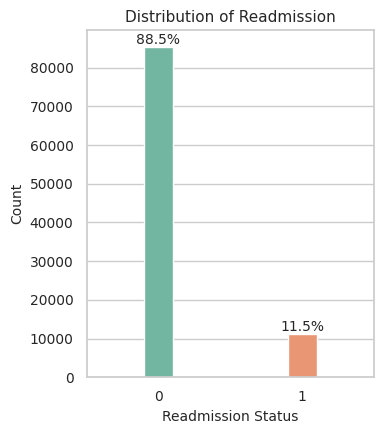

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of readmission
plt.figure(figsize=(4, 4.5))
sns.countplot(data=df, x='readmitted', palette='Set2', width=0.2)  # Adjust the width value as desired
plt.title('Distribution of Readmission', fontsize=11)
plt.xlabel('Readmission Status', fontsize=10)
plt.ylabel('Count', fontsize=10)

# Add value annotations
total = len(df['readmitted'])
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.gca().annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()




## Visualization of Hospital Stay Duration and Readmission Relationship: A Violin Plot Analysis"

The plot visualizes the relationship between the "Time in Hospital" and "Readmission" variables.

The plot aims to provide a clear visual representation of the relationship between the "Time in Hospital" and "Readmission" variables, enabling easier interpretation and understanding of the data.

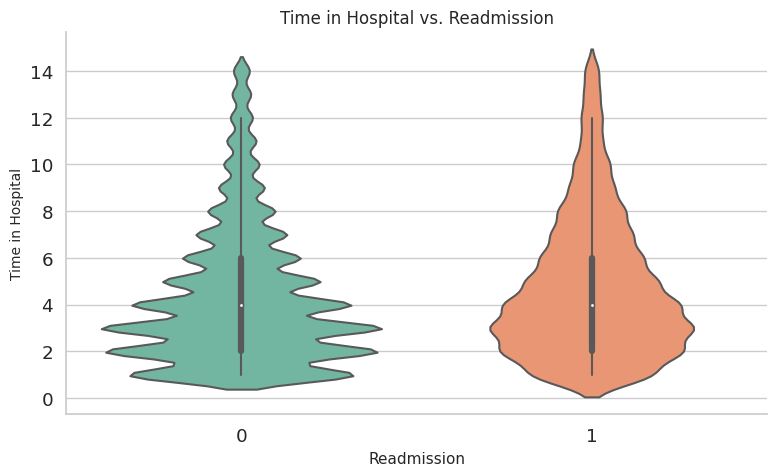

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.2)

fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(data=df, x='readmitted', y='time_in_hospital', palette='Set2')

ax.set_xlabel('Readmission', fontsize=11)
ax.set_ylabel('Time in Hospital', fontsize=10)
plt.title('Time in Hospital vs. Readmission', fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## Plot the relationship between "Age" and "Readmission" using a ............. plot:

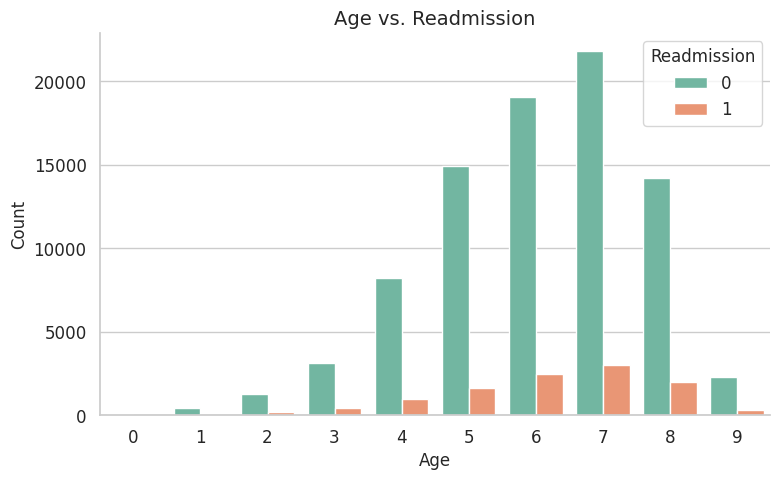

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.1)

fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x='age', hue='readmitted', palette='Set2')

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.title('Age vs. Readmission', fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend = plt.legend(title='Readmission', loc='upper right')
legend.get_title().set_fontsize('12')  # Adjust legend title font size
for label in legend.get_texts():  # Adjust legend labels font size
    label.set_fontsize('12')

plt.tight_layout()
plt.show()



##  Plot the relationship between "Number of Medication Used" and "Readmission"


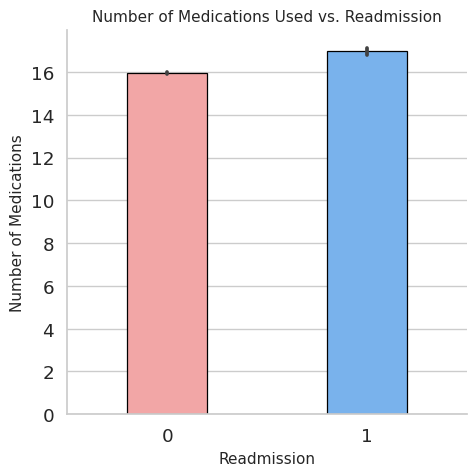

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.2)

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=df, x='readmitted', y='num_medications', palette=['#FF9999', '#66B2FF'], linewidth=0.9, edgecolor='black', width=0.4)

ax.set_xlabel('Readmission', fontsize=11)
ax.set_ylabel('Number of Medications', fontsize=11)
plt.title('Number of Medications Used vs. Readmission', fontsize=11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## Plot the relationship between "Gender" and "Readmission" :

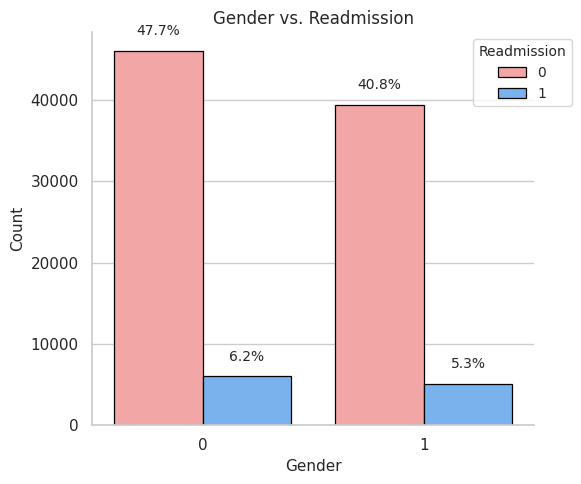

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.0)

fig, ax = plt.subplots(figsize=(6, 5))
sns.countplot(data=df, x='gender', hue='readmitted', palette=['#FF9999', '#66B2FF'], linewidth=0.9, edgecolor='black')

ax.set_xlabel('Gender', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
plt.title('Gender vs. Readmission', fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend = plt.legend(title='Readmission', loc='upper right', fontsize='small', bbox_to_anchor=(1.1, 1))
legend.get_title().set_fontsize('10')  # Adjust legend title font size
for label in legend.get_texts():  # Adjust legend labels font size
    label.set_fontsize('10')

# Add percentage labels on top of each bar
total = len(df)  # Total count of data points
for p in ax.patches:
    height = p.get_height()
    percentage = f'{height/total:.1%}'
    x = p.get_x() + p.get_width() / 2
    y = height + 0.02 * total  # Adjust the vertical position of the label
    ax.annotate(percentage, (x, y), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## Change of Medication VS. Readmission

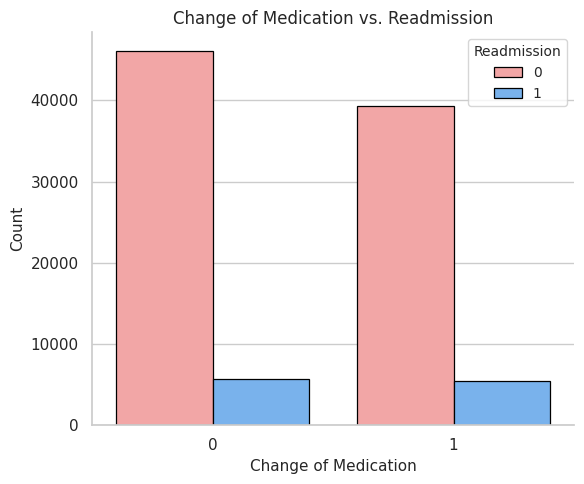

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.0)

fig, ax = plt.subplots(figsize=(6, 5))
sns.countplot(data=df, x='change', hue='readmitted', palette=['#FF9999', '#66B2FF'], linewidth=0.9, edgecolor='black')

ax.set_xlabel('Change of Medication', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
plt.title('Change of Medication vs. Readmission', fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend = plt.legend(title='Readmission', loc='upper right', fontsize='small', bbox_to_anchor=(1.0, 1))
legend.get_title().set_fontsize('10')  # Adjust legend title font size
for label in legend.get_texts():  # Adjust legend labels font size
    label.set_fontsize('10')

plt.tight_layout()
plt.show()


## Plot the hemoglobin A1C result against Readmission:


One common test result that can be used to plot it against Readmission is the A1C result. The A1C test measures the average blood sugar levels over the past 2-3 months and is commonly used to diagnose and monitor diabetes.

The A1C test, also known as the hemoglobin A1C or glycated hemoglobin test, measures the average blood sugar levels over the past 2-3 months. It provides an indication of long-term blood sugar control and is commonly used to diagnose and monitor diabetes.


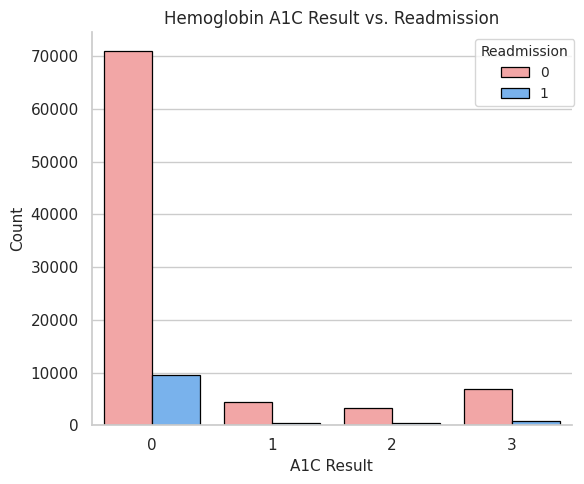

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.0)

fig, ax = plt.subplots(figsize=(6, 5))
sns.countplot(data=df, x='A1Cresult', hue='readmitted', palette=['#FF9999', '#66B2FF'], linewidth=0.9, edgecolor='black')

ax.set_xlabel('A1C Result', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
plt.title('Hemoglobin A1C Result vs. Readmission', fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend = plt.legend(title='Readmission', loc='upper right', fontsize='small', bbox_to_anchor=(1.02, 1))
legend.get_title().set_fontsize('10')  # Adjust legend title font size
for label in legend.get_texts():  # Adjust legend labels font size
    label.set_fontsize('10')

plt.tight_layout()
plt.show()


## The plot "Number of Lab Procedures vs. Readmission" aims to explore the relationship between the number of lab procedures performed on patients and their readmission status in a hospital setting.

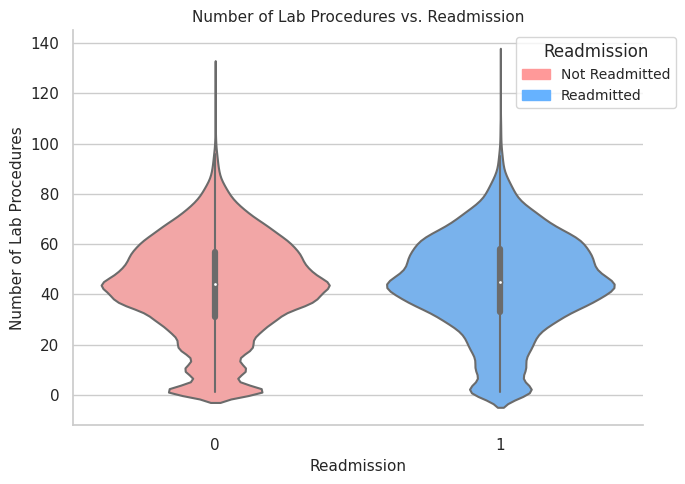

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set(style='whitegrid', font_scale=1.0)

fig, ax = plt.subplots(figsize=(7, 5))
sns.violinplot(data=df, x='readmitted', y='num_lab_procedures', palette=['#FF9999', '#66B2FF'])

ax.set_xlabel('Readmission', fontsize=11)
ax.set_ylabel('Number of Lab Procedures', fontsize=11)
plt.title('Number of Lab Procedures vs. Readmission', fontsize=11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create custom legend
legend_labels = ['Not Readmitted', 'Readmitted']
legend_colors = ['#FF9999', '#66B2FF']
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=legend_patches, title='Readmission', loc='upper right', fontsize='small', bbox_to_anchor=(1.07, 1))

plt.tight_layout()
plt.show()


# **Data Preprocessing: Pre-Modeling Phase**

# convert age categories to mid-point values


In [ ]:
df['age'] = df['age'].astype('int64')
print(df.age.value_counts())

age_dict = {8: 75, 7: 65, 6: 55, 9: 85, 5: 45, 4: 35, 10: 95, 3: 25, 2: 15, 1: 5}
df['age'] = df.age.map(age_dict)
print(df.age.value_counts())


7    24815
6    21521
5    16546
8    16223
4     9208
3     3538
9     2594
2     1471
1      466
0       64
Name: age, dtype: int64
65.0    24815
55.0    21521
45.0    16546
75.0    16223
35.0     9208
25.0     3538
85.0     2594
15.0     1471
5.0       466
Name: age, dtype: int64


# convert data type of nominal features in dataframe to 'object' type


In [ ]:
nominal_features = ['race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                    'diag_1', 'diag_2', 'diag_3']

nominal_columns = df[nominal_features].columns
print("Nominal Features:")
print(nominal_columns)


Nominal Features:
Index(['race', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'diag_1', 'diag_2', 'diag_3'],
      dtype='object')


In [ ]:
df.shape

(96446, 67)

In [ ]:
num_columns = df.shape[1]
print("Number of columns:", num_columns)


Number of columns: 67


For Number of medication, we calculates the sum of values across multiple columns and provides the frequency distribution of the resulting sums. We are interested in understanding the distribution or frequency of the combined values from those columns, then this code can be useful.

In [ ]:
df['nummed'] = 0

for col in medication_columns:
    df['nummed'] = df['nummed'] + df[col]

nummed_counts = df['nummed'].value_counts()
print(nummed_counts)


1    44589
0    22156
2    20901
3     7448
4     1290
5       57
6        5
Name: nummed, dtype: int64


In [ ]:
df.shape

(96446, 68)

# performing the log transformation for the columns determined to be needing it below


In [ ]:
import pandas as pd
import numpy as np

columns_to_transform = ['service_utilization', 'number_outpatient', 'num_procedures', 'num_medications',
                        'number_emergency', 'time_in_hospital', 'number_inpatient', 'num_lab_procedures',
                        'number_diagnoses', 'nummed']

statdataframe = pd.DataFrame()
statdataframe['numeric_column'] = columns_to_transform
skew_before = []
skew_after = []
kurt_before = []
kurt_after = []
standard_deviation_before = []
standard_deviation_after = []
log_transform_needed = []
log_type = []

for col in columns_to_transform:
    skewval = df[col].skew()
    skew_before.append(skewval)

    kurtval = df[col].kurtosis()
    kurt_before.append(kurtval)

    sdval = df[col].std()
    standard_deviation_before.append(sdval)

    if abs(skewval) > 2 or abs(kurtval) > 2:
        log_transform_needed.append('Yes')

        if len(df[df[col] == 0]) / len(df) <= 0.02:
            log_type.append('log')
            transformed_data = np.log(df[df[col] > 0][col])
        else:
            log_type.append('log1p')
            transformed_data = np.log1p(df[df[col] >= 0][col])

        skewvalnew = transformed_data.skew()
        skew_after.append(skewvalnew)

        kurtvalnew = transformed_data.kurtosis()
        kurt_after.append(kurtvalnew)

        sdvalnew = transformed_data.std()
        standard_deviation_after.append(sdvalnew)

        df[col] = transformed_data  # Apply the log transformation to the column
    else:
        log_type.append('NA')
        log_transform_needed.append('No')

        skew_after.append(skewval)
        kurt_after.append(kurtval)
        standard_deviation_after.append(sdval)

statdataframe['skew_before'] = skew_before
statdataframe['kurtosis_before'] = kurt_before
statdataframe['standard_deviation_before'] = standard_deviation_before
statdataframe['log_transform_needed'] = log_transform_needed
statdataframe['log_type'] = log_type
statdataframe['skew_after'] = skew_after
statdataframe['kurtosis_after'] = kurt_after
statdataframe['standard_deviation_after'] = standard_deviation_after

#print(statdataframe)
print(df.shape)

(96446, 68)


In [ ]:
statdataframe

,numeric_column,skew_before,kurtosis_before,standard_deviation_before,log_transform_needed,log_type,skew_after,kurtosis_after,standard_deviation_after
0,service_utilization,5.312374,67.194018,2.315789,Yes,log1p,1.097244,0.497241,0.665656
1,number_outpatient,8.767489,146.244961,1.280061,Yes,log1p,2.708627,7.648535,0.432949
2,num_procedures,1.313236,0.856100,1.703183,No,NA,1.313236,0.856100,1.703183
3,num_medications,1.339187,3.549325,8.072516,Yes,log,-0.726555,1.859425,0.530564
4,number_emergency,22.695921,1165.140400,0.948089,Yes,log1p,3.614471,15.854105,0.318742
5,time_in_hospital,1.127510,0.839050,2.982330,No,NA,1.127510,0.839050,2.982330
6,number_inpatient,3.566269,20.044813,1.269975,Yes,log1p,1.425127,1.319186,0.513389
7,num_lab_procedures,-0.240626,-0.253275,19.656782,No,NA,-0.240626,-0.253275,19.656782
8,number_diagnoses,-0.807741,-0.372558,1.836659,No,NA,-0.807741,-0.372558,1.836659
9,nummed,0.676983,0.277124,0.923336,No,NA,0.676983,0.277124,0.923336


Performing the log transformation on the columns that require it based on the analysis performed earlier.

This code loops through the statdataframe DataFrame and checks if the column needs a log transformation. If it does, it performs the corresponding log transformation on the column and adds a new column with the transformed values to the DataFrame.

In [ ]:
for i in range(len(statdataframe)):
    if statdataframe['log_transform_needed'][i] == 'Yes':
        colname = str(statdataframe['numeric_column'][i])

        if statdataframe['log_type'][i] == 'log':
            df = df[df[colname] > 0]
            df[colname + "_log"] = np.log(df[colname])

        elif statdataframe['log_type'][i] == 'log1p':
            df = df[df[colname] >= 0]
            df[colname + "_log1p"] = np.log1p(df[colname])


In [ ]:
print(df.shape)

(96212, 73)


In [ ]:
numerics = list(set(list(df._get_numeric_data().columns))- {'readmitted'})

Convert the data type of the specified nominal features in the DataFrame df to 'object' type for aggregating,

In [ ]:
# Define a list to store the nominal feature column names
nominal_columns = []

# Iterate over each column in the DataFrame
for column in df.columns:
    # Check if the column has a data type of 'object' or 'category'
    if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
        nominal_columns.append(column)

# Print the list of nominal feature column names
print(nominal_columns)

['race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3']


In [ ]:
# List of nominal feature column names
nominal_features = ['race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                    'diag_1', 'diag_2', 'diag_3', 'gender', 'age','max_glu_serum','nummed']

# Convert nominal features to 'object' type
df[nominal_features] = df[nominal_features].astype('object')

In [ ]:
columns = ['race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1',
           'diag_2', 'diag_3', 'gender', 'age','max_glu_serum','nummed']

# Get the data types of the specified columns
column_data_types = df[columns].dtypes

# Print the data types
print(column_data_types)

race                        object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
diag_1                      object
diag_2                      object
diag_3                      object
gender                      object
age                         object
max_glu_serum               object
nummed                      object
dtype: object


In [ ]:
columns = ['nummed', 'age']

# Get the data types of the specified columns
column_data_types = df[columns].dtypes

# Print the data types
print(column_data_types)


nummed    object
age       object
dtype: object


In [ ]:
dfcopy = df.copy(deep = True)

replaces all the values in the 'readmitted' column of the DataFrame df with 0 if the value is 2, otherwise it keeps the original value.

In [ ]:
df['readmitted'] = df['readmitted'].apply(lambda x: 0 if x == 2 else x)
# print(df['readmitted'].to_string(index=False))

In [ ]:
df.shape

(96212, 73)

Creates a new DataFrame df2 that contains only the rows of df where the values in the 'patient_nbr' column are unique.

In [ ]:
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape

(67413, 73)

In [ ]:
print(df2.head(5))

   encounter_id  patient_nbr             race gender   age admission_type_id  \
1        149190     55629189        Caucasian      0   5.0  Emergency/Urgent   
2         64410     86047875  AfricanAmerican      0  15.0  Emergency/Urgent   
3        500364     82442376        Caucasian      1  25.0  Emergency/Urgent   
4         16680     42519267        Caucasian      1  35.0  Emergency/Urgent   
5         35754     82637451        Caucasian      1  45.0  Emergency/Urgent   

  discharge_disposition_id admission_source_id  time_in_hospital  \
1       Discharged to home      Emergency Room                 3   
2       Discharged to home      Emergency Room                 2   
3       Discharged to home      Emergency Room                 2   
4       Discharged to home      Emergency Room                 1   
5       Discharged to home            Referral                 3   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
1                  59            

# standardize function


In [ ]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [ ]:
from numpy import sqrt

# Check if the selected columns are numeric
numeric_cols = [col for col in numerics if col in df2.columns and df2[col].dtype == 'float64']

# Standardize only the numeric columns
df2.loc[:, numeric_cols] = standardize(df2.loc[:, numeric_cols])

import scipy as sp
df2 = df2[(np.abs(sp.stats.zscore(df2[numeric_cols])) < 3).all(axis=1)]

<ipython-input-170-c415f75b71f3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, numeric_cols] = standardize(df2.loc[:, numeric_cols])


In [ ]:
columns_to_drop = ['metformin-rosiglitazone', 'metformin-pioglitazone_changed',
                   'metformin-rosiglitazone_changed', 'glimepiride-pioglitazone_changed',
                   'glipizide-metformin_changed', 'troglitazone_changed', 'tolbutamide_changed',
                   'acetohexamide_changed', 'glimepiride-pioglitazone'	]

df2 = df2.drop(columns_to_drop, axis=1)


In [ ]:
#columns_to_drop = [ 'glimepiride-pioglitazone'	]

#df2 = df2.drop(columns_to_drop, axis=1)

In [ ]:
columns_to_drop = [ 'tolazamide_changed'	]

df2 = df2.drop(columns_to_drop, axis=1)

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap

# Create a custom colormap
my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())

# Remove 'patient_nbr' and 'encounter_id' columns from the dataframe before calculating correlation
columns_to_drop = ['patient_nbr', 'encounter_id']
df_filtered = df2.drop(columns_to_drop, axis=1)

# Calculate the correlation matrix
correlation_matrix = df_filtered.corr(method='pearson')

# Create a table representation of the correlation matrix
table = correlation_matrix.style.background_gradient(cmap=my_cmap, axis=0)

# Display the table
display(table)

<ipython-input-174-b1d7589a7b11>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_filtered.corr(method='pearson')


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-pioglitazone,change,diabetesMed,readmitted,service_utilization,metformin_changed,repaglinide_changed,nateglinide_changed,chlorpropamide_changed,glimepiride_changed,glipizide_changed,glyburide_changed,pioglitazone_changed,rosiglitazone_changed,acarbose_changed,miglitol_changed,insulin_changed,glyburide-metformin_changed,service_utilization_log1p,number_outpatient_log1p,num_medications_log,number_emergency_log1p,number_inpatient_log1p
time_in_hospital,1.000000,0.335168,0.181745,0.444513,-0.030806,-0.004579,0.050379,0.221911,0.070230,-0.008873,0.032389,0.006213,0.000886,0.011655,0.013275,0.016410,0.029184,0.003536,-0.000194,0.000283,0.005166,-0.002983,0.004753,-0.006074,0.106048,-0.000237,0.001377,0.002286,0.103906,0.059305,0.053528,0.003356,0.039139,0.032110,0.012113,-0.002295,0.041711,0.067092,0.061778,0.043549,0.033849,0.003321,-0.002594,0.127721,-0.002760,0.004140,-0.031244,0.422076,-0.004579,0.050379
num_lab_procedures,0.335168,1.000000,0.043629,0.248918,-0.042442,0.004637,0.044700,0.143905,0.261748,-0.044949,0.008275,-0.007578,-0.002657,-0.005333,0.005118,0.020771,0.005309,0.000032,-0.014062,-0.008059,0.000004,-0.004370,0.004863,-0.000578,0.110443,-0.012840,-0.004103,-0.004055,0.075713,0.040493,0.026580,-0.005707,0.025590,0.019401,-0.001936,-0.003218,0.031216,0.044032,0.035723,0.025614,0.019892,0.005291,0.001905,0.114245,0.000206,-0.005753,-0.043014,0.237945,0.004637,0.044700
num_procedures,0.181745,0.043629,1.000000,0.359181,-0.021403,-0.030015,-0.016140,0.064389,-0.021299,-0.051741,0.002158,-0.006994,0.006620,0.004427,0.005757,0.006286,0.006336,-0.000618,0.011799,0.007663,0.000014,-0.000205,-0.005794,0.000360,0.018735,-0.007368,-0.003691,-0.001070,-0.000278,-0.011319,0.000795,-0.036386,-0.015153,0.003948,0.001038,-0.001002,0.005692,0.011012,0.004231,-0.002046,0.007844,0.000215,-0.004731,0.016971,-0.007049,-0.036724,-0.021032,0.333974,-0.030015,-0.016140
num_medications,0.444513,0.248918,0.359181,1.000000,0.031451,0.010970,0.035787,0.259393,0.018097,0.076441,0.027355,0.028881,-0.000088,0.045370,0.007147,0.060309,0.048152,0.001401,0.075059,0.058339,0.017198,0.004496,0.004149,-0.001008,0.208654,0.010332,0.004756,0.002835,0.243622,0.190830,0.037727,0.044392,0.039921,0.015703,0.009750,-0.002525,0.032686,0.044254,0.033575,0.029045,0.026252,0.007126,-0.003675,0.201802,-0.000031,0.044809,0.032170,0.990054,0.010970,0.035787
number_outpatient,-0.030806,-0.042442,-0.021403,0.031451,1.000000,0.098660,0.055868,0.056545,-0.032455,0.024073,-0.000665,0.014407,-0.004757,0.000266,-0.001288,0.004319,0.010070,-0.002059,0.018773,0.009602,0.012328,0.003339,-0.002231,-0.004673,-0.008403,-0.001177,0.013754,-0.001288,0.025340,0.024079,0.009774,0.733418,-0.001769,-0.000584,0.003692,-0.002577,0.005455,-0.005866,0.007401,-0.004339,-0.000123,0.001616,0.010900,0.011603,0.006731,0.709499,0.998073,0.033834,0.098660,0.055868
number_emergency,-0.004579,0.004637,-0.030015,0.010970,0.098660,1.000000,0.075604,0.049781,-0.011109,-0.003192,0.006435,0.007177,-0.007683,0.004674,-0.000952,0.000976,-0.014385,-0.003689,0.015431,0.012160,-0.001272,0.011993,-0.001650,0.001828,0.036811,0.001825,-0.002520,-0.000952,0.039452,0.033891,0.011285,0.489133,-0.004720,-0.003615,0.003010,-0.001905,-0.004357,-0.002420,-0.005826,-0.004444,-0.002078,-0.003012,-0.001347,0.053707,0.010154,0.485050,0.098970,0.012846,1.000000,0.075604
number_inpatient,0.050379,0.044700,-0.016140,0.035787,0.055868,0.075604,1.000000,0.050674,-0.040942,-0.020536,0.009143,-0.002087,0.004233,0.004733,-0.001247,0.001209,-0.002697,-0.001113,-0.003220,-0.004685,-0.003014,-0.002358,-0.002160,-0.003879,0.019345,-0.010267,-0.003300,-0.001

In [ ]:
# Save the filtered dataframe to mydata
mydata = df_filtered

Divide the dataset mydata into X and y, where y represents the target variable 'readmitted' and X represents the remaining features, you can use the following code:

In [ ]:
import pandas as pd

# Assign the target variable 'readmitted' to y
y = mydata['readmitted']

# Assign the remaining features to X
X = mydata.drop('readmitted', axis=1)

# Display the shapes of X and y
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)


Shape of X: (60987, 60)
Shape of y: (60987,)


In [ ]:
mydata['readmitted'].value_counts()

0    55759
1     5228
Name: readmitted, dtype: int64

# **Logistic Regression Model**

In [ ]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Assign the target variable 'readmitted' to y
y = mydata['readmitted']

# Assign the remaining features to X
X = mydata.drop('readmitted', axis=1)

# Perform one-hot encoding on the categorical variables
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_encoded = pd.get_dummies(X)

# Apply SMOTE to oversample the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create an instance of Logistic Regression model with max_iter set to 1000
logreg = LogisticRegression(max_iter=1000)

# Fit the model on the training data
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11249
           1       1.00      0.91      0.95     11055

    accuracy                           0.95     22304
   macro avg       0.96      0.95      0.95     22304
weighted avg       0.96      0.95      0.95     22304



In [ ]:
import pandas as pd
from IPython.display import display

# Assuming you have the y_test and y_pred variables available

# Create the prediction_table using crosstab
prediction_table = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predict'), margins=True)

# Style the "Predict" row and "Actual" column with colors
styled_table = prediction_table.style.apply(lambda x: ['background: lightblue' if x.name == 'Predict' else '' for i in x], axis=1)
styled_table = styled_table.apply(lambda x: ['background: lightgreen' if x.name == 'Actual' else '' for i in x], axis=0)

# Print predicted values vs. actual values in a tabular format
print("Predicted values vs. Actual values:")
display(styled_table)

Predicted values vs. Actual values:


Predict,0,1,All
Actual,,,
0,2275,1812,4087
1,213,183,396
All,2488,1995,4483


# Calculate the mean squared error (MSE)

In [ ]:
print("y_test:", y_test)
print("y_pred:", y_pred)

y_test: 13069    1
264      0
15249    0
35532    0
14843    0
        ..
67022    1
18702    0
98140    1
60467    0
15662    1
Name: readmitted, Length: 22304, dtype: int64
y_pred: [0 0 0 ... 1 0 0]


Mean Squared Error (MSE): 0.04


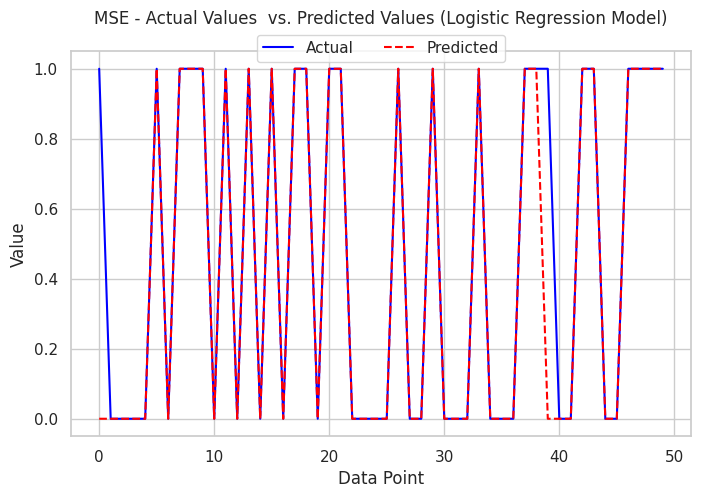

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test[:50], y_pred[:50])

# Print the mean squared error (MSE)
print("Mean Squared Error (MSE):", mse)

# Generate an array of indices for the data points
indices = np.arange(50)

# Set the figure size for better visualization
plt.figure(figsize=(8, 5))

# Plot the line plot of y_test and y_pred
plt.plot(indices, y_test[:50], color='blue', label='Actual')
plt.plot(indices, y_pred[:50], color='red', linestyle='dashed', label='Predicted')

# Set the title and legend
plt.title('MSE - Actual Values  vs. Predicted Values (Logistic Regression Model)', y=1.05)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.063), ncol=2)

# Set the x and y axis labels
plt.xlabel('Data Point')
plt.ylabel('Value')

# Show the plot
plt.show()


In [ ]:
# Calculate the accuracy and round it to 2 digits
accuracy = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy:", accuracy)

Accuracy: 0.95


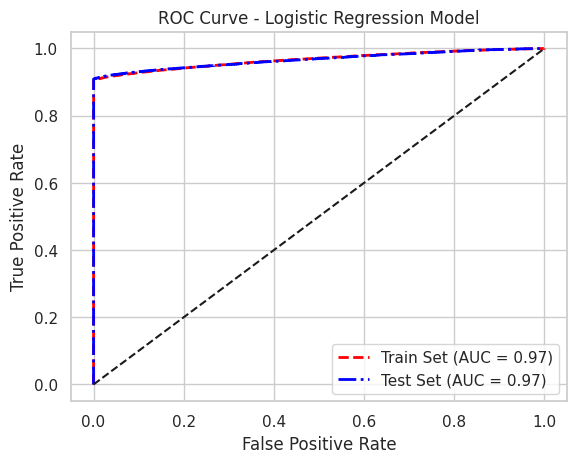

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the probabilities for each class in the train set
y_train_pred_prob = logreg.predict_proba(X_train)[:, 1]

# Calculate the probabilities for each class in the test set
y_test_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC score for train set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
auc_train = roc_auc_score(y_train, y_train_pred_prob)

# Calculate the ROC curve and AUC-ROC score for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)

# Plot the ROC curves for train and test sets
plt.plot(fpr_train, tpr_train, color='red', linestyle='--', label='Train Set (AUC = {:.2f})'.format(auc_train), linewidth=2)
plt.plot(fpr_test, tpr_test, color='blue', linestyle='-.', label='Test Set (AUC = {:.2f})'.format(auc_test), linewidth=2)

# Add the reference line
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression Model')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()


# **Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of Random Forest model with 1000 estimators
rf = RandomForestClassifier(n_estimators=1000)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)


In [ ]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11249
           1       1.00      0.91      0.95     11055

    accuracy                           0.96     22304
   macro avg       0.96      0.95      0.96     22304
weighted avg       0.96      0.96      0.96     22304



In [ ]:
import pandas as pd
from IPython.display import display

# Assuming you have the y_test and y_pred variables available

# Create the prediction_table using crosstab
prediction_table = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predict'), margins=True)

# Style the "Predict" row and "Actual" column with colors
styled_table = prediction_table.style.apply(lambda x: ['background: lightblue' if x.name == 'Predict' else '' for i in x], axis=1)
styled_table = styled_table.apply(lambda x: ['background: lightgreen' if x.name == 'Actual' else '' for i in x], axis=0)

# Print predicted values vs. actual values in a tabular format
print("Predicted values vs. Actual values:")
display(styled_table)


Predicted values vs. Actual values:


Predict,0,1,All
Actual,,,
0,2274,1813,4087
1,213,183,396
All,2487,1996,4483


In [ ]:
# Calculate the accuracy and round it to 2 digits
accuracy = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy:", accuracy)


Accuracy: 0.96


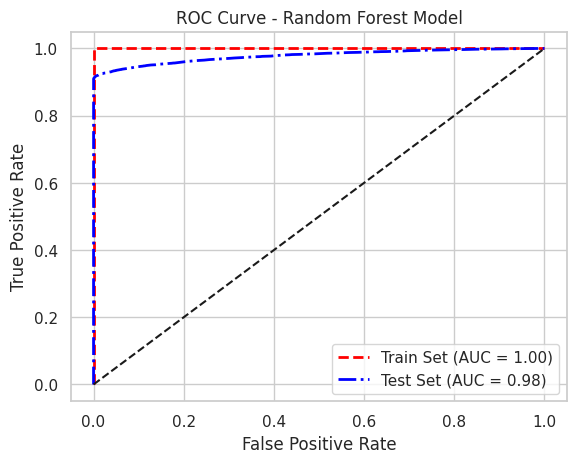

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the probabilities for each class in the train set
y_train_pred_prob = rf.predict_proba(X_train)[:, 1]

# Calculate the probabilities for each class in the test set
y_test_pred_prob = rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC score for train set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
auc_train = roc_auc_score(y_train, y_train_pred_prob)

# Calculate the ROC curve and AUC-ROC score for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)

# Plot the ROC curves for train and test sets
plt.plot(fpr_train, tpr_train, color='red', linestyle='--', label='Train Set (AUC = {:.2f})'.format(auc_train), linewidth=2)
plt.plot(fpr_test, tpr_test, color='blue', linestyle='-.', label='Test Set (AUC = {:.2f})'.format(auc_test), linewidth=2)

# Add the reference line
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Model')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()


# Calculate the mean squared error (MSE)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Create and train the RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = rf.predict(X_test)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the mean squared error (MSE)
print("Mean Squared Error (MSE):", mse)



Mean Squared Error (MSE): 0.044745337159253946


# **LightGBM Model**

In [ ]:
import lightgbm as lgb

# Rename columns to remove special characters or spaces
X_train.columns = ["".join(c if c.isalnum() else "_" for c in str(col)) for col in X_train.columns]
X_test.columns = ["".join(c if c.isalnum() else "_" for c in str(col)) for col in X_test.columns]

# Create an instance of LightGBM model
lgb_model = lgb.LGBMClassifier()

# Fit the model on the training data
lgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgb_model.predict(X_test)


In [ ]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11249
           1       1.00      0.91      0.95     11055

    accuracy                           0.95     22304
   macro avg       0.96      0.95      0.95     22304
weighted avg       0.96      0.95      0.95     22304



In [ ]:
import pandas as pd
from IPython.display import display

# Assuming you have the y_test and y_pred variables available

# Create the prediction_table using crosstab
prediction_table = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predict'), margins=True)

# Style the "Predict" row and "Actual" column with colors
styled_table = prediction_table.style.apply(lambda x: ['background: lightblue' if x.name == 'Predict' else '' for i in x], axis=1)
styled_table = styled_table.apply(lambda x: ['background: lightgreen' if x.name == 'Actual' else '' for i in x], axis=0)

# Print predicted values vs. actual values in a tabular format
print("Predicted values vs. Actual values:")
display(styled_table)


Predicted values vs. Actual values:


Predict,0,1,All
Actual,,,
0,2273,1814,4087
1,212,184,396
All,2485,1998,4483


# Calculate the mean squared error (MSE)


Mean Squared Error (MSE): 0.04


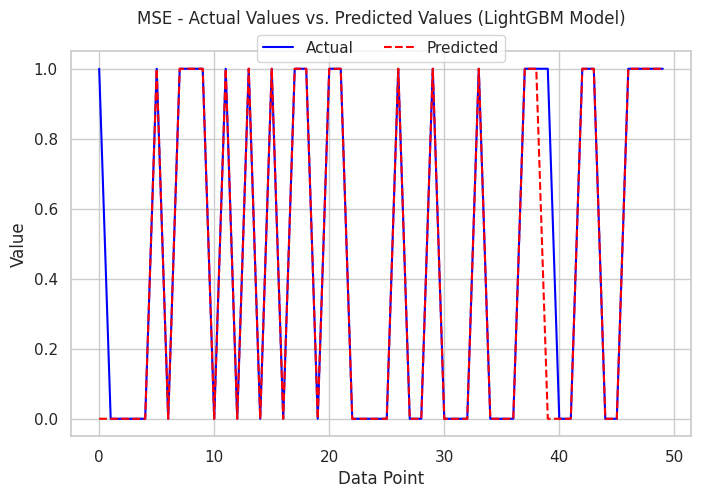

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test[:50], y_pred[:50])

# Print the mean squared error (MSE)
print("Mean Squared Error (MSE):", mse)

# Generate an array of indices for the data points
indices = np.arange(50)

# Set the figure size for better visualization
plt.figure(figsize=(8, 5))

# Plot the line plot of y_test and y_pred
plt.plot(indices, y_test[:50], color='blue', label='Actual')
plt.plot(indices, y_pred[:50], color='red', linestyle='dashed', label='Predicted')

# Set the title and legend
plt.title('MSE - Actual Values vs. Predicted Values (LightGBM Model)', y=1.05)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.063), ncol=2)

# Set the x and y axis labels
plt.xlabel('Data Point')
plt.ylabel('Value')

# Show the plot
plt.show()


In [ ]:
# Calculate the accuracy and round it to 2 digits
accuracy = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy:", accuracy)


Accuracy: 0.95


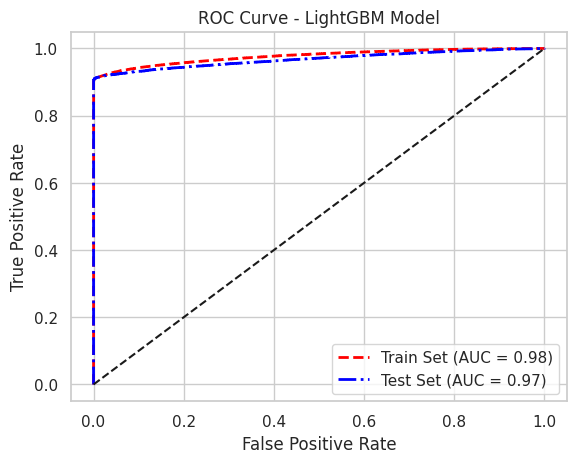

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the probabilities for each class in the train set
y_train_pred_prob = lgb_model.predict_proba(X_train)[:, 1]

# Calculate the probabilities for each class in the test set
y_test_pred_prob = lgb_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC score for train set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
auc_train = roc_auc_score(y_train, y_train_pred_prob)

# Calculate the ROC curve and AUC-ROC score for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)

# Plot the ROC curves for train and test sets
plt.plot(fpr_train, tpr_train, color='red', linestyle='--', label='Train Set (AUC = {:.2f})'.format(auc_train), linewidth=2)
plt.plot(fpr_test, tpr_test, color='blue', linestyle='-.', label='Test Set (AUC = {:.2f})'.format(auc_test), linewidth=2)

# Add the reference line
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Model')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()


# **XGBoost Model**

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Assign the target variable 'readmitted' to y
y = mydata['readmitted']

# Assign the remaining features to X
X = mydata.drop('readmitted', axis=1)

# Perform one-hot encoding on the categorical variables
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_encoded = pd.get_dummies(X)

# Apply SMOTE to oversample the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create an instance of XGBoost model
xgb_model = xgb.XGBClassifier()

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)


In [ ]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11249
           1       1.00      0.91      0.95     11055

    accuracy                           0.95     22304
   macro avg       0.96      0.95      0.95     22304
weighted avg       0.96      0.95      0.95     22304



In [ ]:
import pandas as pd
from IPython.display import display

# Assuming you have the y_test and y_pred variables available

# Create the prediction_table using crosstab
prediction_table = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predict'), margins=True)

# Calculate the correct and incorrect predictions
correct_predictions = prediction_table.iloc[0, 0] + prediction_table.iloc[1, 1]
incorrect_predictions = prediction_table.iloc[0, 1] + prediction_table.iloc[1, 0]

# Add the correct and incorrect prediction counts to the table
prediction_table.loc['Correct Predictions'] = [prediction_table.iloc[0, 0], prediction_table.iloc[1, 1], correct_predictions]
prediction_table.loc['Incorrect Predictions'] = [prediction_table.iloc[0, 1], prediction_table.iloc[1, 0], incorrect_predictions]

# Set the caption for the table
caption = "Distribution of Predicted Values vs. Actual Values"

# Display the table with caption
display(prediction_table.style.set_caption(caption))



Predict,0,1,All
Actual,,,
0,2269,1818,4087
1,212,184,396
All,2481,2002,4483
Correct Predictions,2269,184,2453
Incorrect Predictions,1818,212,2030


In [ ]:
# Calculate the accuracy and round it to 2 digits
accuracy = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy:", accuracy)


Accuracy: 0.95


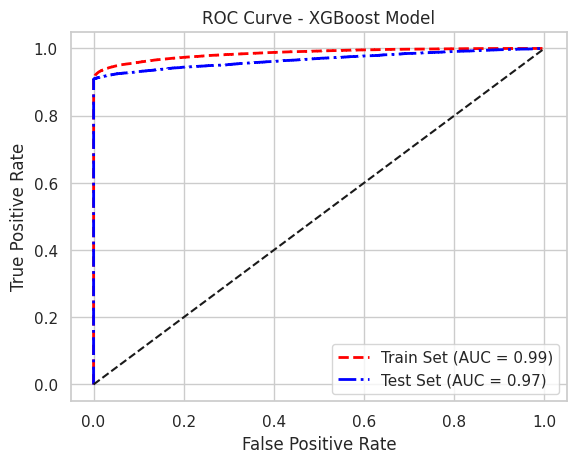

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Calculate the predicted probabilities for each class in the train set
y_train_pred_prob = xgb_model.predict_proba(X_train)[:, 1]

# Calculate the predicted probabilities for each class in the test set
y_test_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC score for train set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
auc_train = roc_auc_score(y_train, y_train_pred_prob)

# Calculate the ROC curve and AUC-ROC score for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)

# Plot the ROC curves for train and test sets
plt.plot(fpr_train, tpr_train, color='red', linestyle='--', label='Train Set (AUC = {:.2f})'.format(auc_train), linewidth=2)
plt.plot(fpr_test, tpr_test, color='blue', linestyle='-.', label='Test Set (AUC = {:.2f})'.format(auc_test), linewidth=2)

# Add the reference line
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Model')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb

# Create and train the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the mean squared error (MSE)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 0.05024681650413624


#Decision Tree method

In [ ]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Assign the target variable 'readmitted' to y
y = mydata['readmitted']

# Assign the remaining features to X
X = mydata.drop('readmitted', axis=1)

# Perform one-hot encoding on the categorical variables
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_encoded = pd.get_dummies(X)

# Apply SMOTE to oversample the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create an instance of Decision Tree model
dt_model = DecisionTreeClassifier()

# Fit the model on the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create the prediction_table using crosstab
prediction_table = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predict'), margins=True)

# Style the "Predict" row and "Actual" column with colors
styled_table = prediction_table.style.apply(lambda x: ['background: lightblue' if x.name == 'Predict' else '' for i in x], axis=1)
styled_table = styled_table.apply(lambda x: ['background: lightgreen' if x.name == 'Actual' else '' for i in x], axis=0)

# Print predicted values vs. actual values in a tabular format
print("Predicted values vs. Actual values:")
display(styled_table)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     11249
           1       0.89      0.92      0.91     11055

    accuracy                           0.91     22304
   macro avg       0.91      0.91      0.91     22304
weighted avg       0.91      0.91      0.91     22304

Predicted values vs. Actual values:


Predict,0,1,All
Actual,,,
0,2021,2066,4087
1,183,213,396
All,2204,2279,4483


Calculating and Printing Accuracy

In [ ]:
# Calculate the accuracy and round it to 2 digits
accuracy = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy:", accuracy)


Accuracy: 0.91


Calculating ROC Curve and AUC-ROC Score for Train and Test Sets, and Plotting the ROC Curves

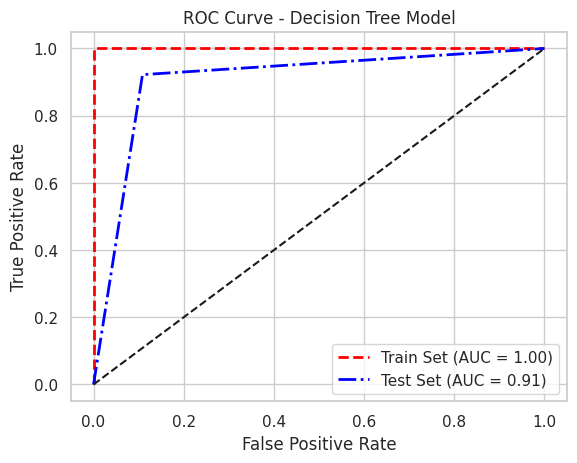

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the predicted probabilities for each class in the train set
y_train_pred_prob = dt_model.predict_proba(X_train)[:, 1]

# Calculate the predicted probabilities for each class in the test set
y_test_pred_prob = dt_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC score for train set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
auc_train = roc_auc_score(y_train, y_train_pred_prob)

# Calculate the ROC curve and AUC-ROC score for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)

# Plot the ROC curves for train and test sets
plt.plot(fpr_train, tpr_train, color='red', linestyle='--', label='Train Set (AUC = {:.2f})'.format(auc_train), linewidth=2)
plt.plot(fpr_test, tpr_test, color='blue', linestyle='-.', label='Test Set (AUC = {:.2f})'.format(auc_test), linewidth=2)

# Add the reference line
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Model')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()


Calculating and Printing Mean Squared Error (MSE)

In [ ]:
from sklearn.metrics import mean_squared_error

# Predict the target values for the test set
y_pred = dt_model.predict(X_test)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the mean squared error (MSE)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 0.09339131994261118


# **Model Comparision**


## 1) **Compare models based on ROC_Curve**

Logistic Regression ; Random Forest  , LightGBM  , XGBoost, and Decision Tree

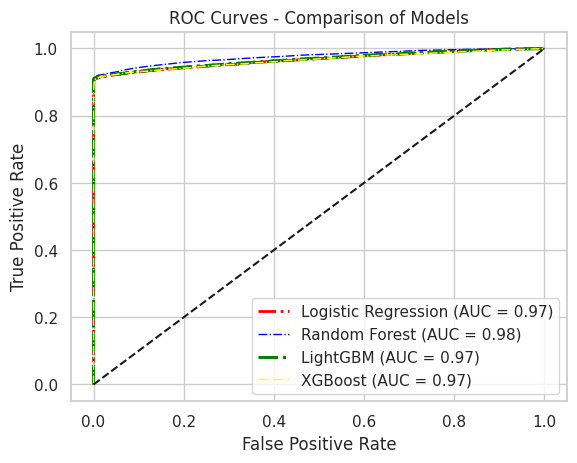

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Logistic Regression
y_pred_prob_logreg = logreg.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logreg)
auc_logreg = roc_auc_score(y_test, y_pred_prob_logreg)

# Random Forest
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# LightGBM
y_pred_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_prob_lgb)
auc_lgb = roc_auc_score(y_test, y_pred_prob_lgb)

# XGBoost
y_pred_xgb = xgb_model.predict(X_test)  # Use 'predict' instead of 'predict_proba'
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

# Plot the ROC curves for all models
plt.plot(fpr_logreg, tpr_logreg, linestyle='-.', linewidth=2, color='red', label='Logistic Regression (AUC = {:.2f})'.format(auc_logreg))
plt.plot(fpr_rf, tpr_rf, linestyle='-.', linewidth=1, color='blue', label='Random Forest (AUC = {:.2f})'.format(auc_rf))
plt.plot(fpr_lgb, tpr_lgb, linestyle='-.', linewidth=2.2, color='green', label='LightGBM (AUC = {:.2f})'.format(auc_lgb))
plt.plot(fpr_xgb, tpr_xgb, linestyle='-.', linewidth=1, color='yellow', label='XGBoost (AUC = {:.2f})'.format(auc_xgb))

# Add the reference line
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparison of Models')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()


# the same the above code but I added  Decision Tree Model

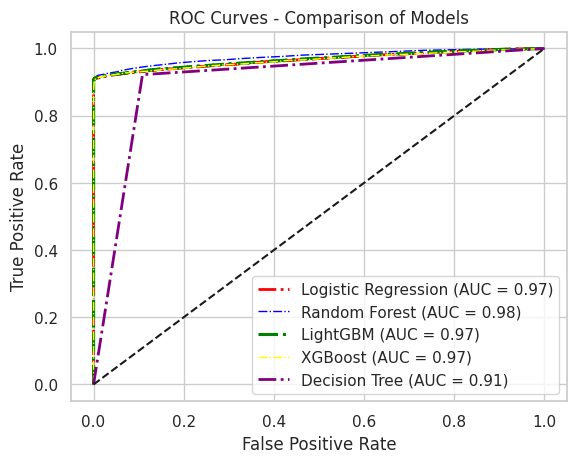

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Logistic Regression
y_pred_prob_logreg = logreg.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logreg)
auc_logreg = roc_auc_score(y_test, y_pred_prob_logreg)

# Random Forest
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# LightGBM
y_pred_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_prob_lgb)
auc_lgb = roc_auc_score(y_test, y_pred_prob_lgb)

# XGBoost
y_pred_xgb = xgb_model.predict(X_test)  # Use 'predict' instead of 'predict_proba'
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

# Decision Tree
y_pred_dt = dt_model.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_pred_dt)

# Plot the ROC curves for all models
plt.plot(fpr_logreg, tpr_logreg, linestyle='-.', linewidth=2, color='red', label='Logistic Regression (AUC = {:.2f})'.format(auc_logreg))
plt.plot(fpr_rf, tpr_rf, linestyle='-.', linewidth=1, color='blue', label='Random Forest (AUC = {:.2f})'.format(auc_rf))
plt.plot(fpr_lgb, tpr_lgb, linestyle='-.', linewidth=2.2, color='green', label='LightGBM (AUC = {:.2f})'.format(auc_lgb))
plt.plot(fpr_xgb, tpr_xgb, linestyle='-.', linewidth=1, color='yellow', label='XGBoost (AUC = {:.2f})'.format(auc_xgb))
plt.plot(fpr_dt, tpr_dt, linestyle='-.', linewidth=2, color='purple', label='Decision Tree (AUC = {:.2f})'.format(auc_dt))

# Add the reference line
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparison of Models')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()


# 2) **Compare models based on accuracy, precision, and recall**

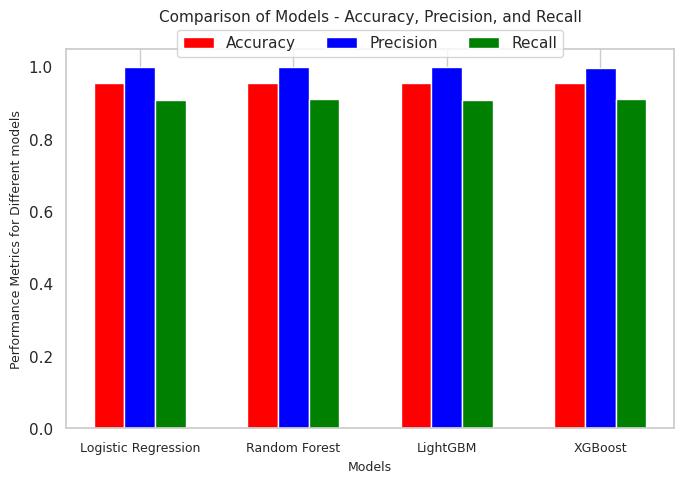

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb

# Define the predictions for each model
y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)

# For binary classification with XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate the accuracy, precision, and recall for each model
accuracy_values = [accuracy_score(y_test, y_pred_logreg),
                   accuracy_score(y_test, y_pred_rf),
                   accuracy_score(y_test, y_pred_lgb),
                   accuracy_score(y_test, y_pred_xgb)]

precision_values = [precision_score(y_test, y_pred_logreg),
                    precision_score(y_test, y_pred_rf),
                    precision_score(y_test, y_pred_lgb),
                    precision_score(y_test, y_pred_xgb)]

recall_values = [recall_score(y_test, y_pred_logreg),
                 recall_score(y_test, y_pred_rf),
                 recall_score(y_test, y_pred_lgb),
                 recall_score(y_test, y_pred_xgb)]


# Set the models' names
model_names = ['Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost']

# Set the x-axis positions for the bars
x = np.arange(len(model_names))

# Set the width of the bars
width = 0.2

# Plot the accuracy, precision, and recall using a grouped bar plot
fig, ax = plt.subplots(figsize=(7, 5))  # Adjust the size of the plot

# Set custom colors
#colors = ['#E4572E', '#F3A712', '#2A9D8F']
colors = ['red', 'blue', 'green']

# Plot the bars with custom colors
rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy', color=colors[0])
rects2 = ax.bar(x, precision_values, width, label='Precision', color=colors[1])
rects3 = ax.bar(x + width, recall_values, width, label='Recall', color=colors[2])

# Set labels and title
ax.set_xlabel('Models', fontsize=9)
ax.set_ylabel('Performance Metrics for Different models', fontsize=9)
ax.set_title('Comparison of Models - Accuracy, Precision, and Recall',fontsize=11, y=1.05)  # Adjust the y value to raise the title


# Set x-axis tick labels and rotate them for better visibility
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=0, fontsize=9)

# Add gridlines
ax.grid(axis='y')

# Move the legend under the title and adjust its position
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=3)  # Adjust the bbox_to_anchor and ncol values

# Adjust plot spacing
fig.tight_layout()

# Show the plot
plt.show()


# the same the above code but I added  Decision Tree Model

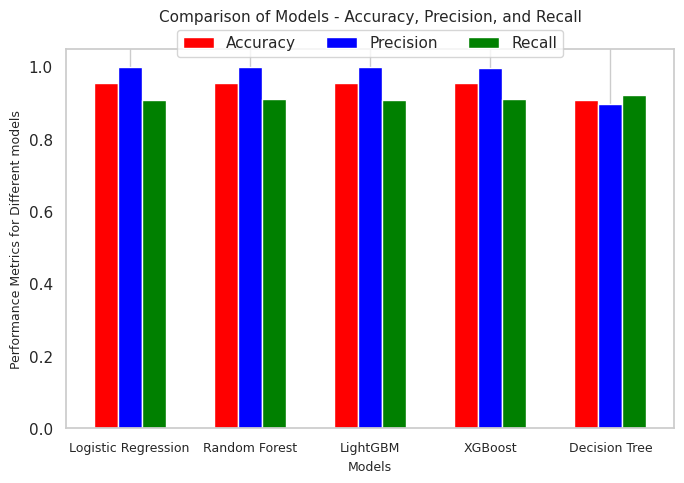

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

# Define the predictions for each model
y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)

# For binary classification with XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Create an instance of the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the Decision Tree model on the training data
dt_model.fit(X_train, y_train)

# Make predictions using the Decision Tree model on the test set
y_pred_dt = dt_model.predict(X_test)

# Calculate the accuracy, precision, and recall for each model
accuracy_values = [accuracy_score(y_test, y_pred_logreg),
                   accuracy_score(y_test, y_pred_rf),
                   accuracy_score(y_test, y_pred_lgb),
                   accuracy_score(y_test, y_pred_xgb),
                   accuracy_score(y_test, y_pred_dt)]

precision_values = [precision_score(y_test, y_pred_logreg),
                    precision_score(y_test, y_pred_rf),
                    precision_score(y_test, y_pred_lgb),
                    precision_score(y_test, y_pred_xgb),
                    precision_score(y_test, y_pred_dt)]

recall_values = [recall_score(y_test, y_pred_logreg),
                 recall_score(y_test, y_pred_rf),
                 recall_score(y_test, y_pred_lgb),
                 recall_score(y_test, y_pred_xgb),
                 recall_score(y_test, y_pred_dt)]


# Set the models' names
model_names = ['Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost', 'Decision Tree']

# Set the x-axis positions for the bars
x = np.arange(len(model_names))

# Set the width of the bars
width = 0.2

# Plot the accuracy, precision, and recall using a grouped bar plot
fig, ax = plt.subplots(figsize=(7, 5))  # Adjust the size of the plot

# Set custom colors
#colors = ['#E4572E', '#F3A712', '#2A9D8F']
colors = ['red', 'blue', 'green']

# Plot the bars with custom colors
rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy', color=colors[0])
rects2 = ax.bar(x, precision_values, width, label='Precision', color=colors[1])
rects3 = ax.bar(x + width, recall_values, width, label='Recall', color=colors[2])

# Set labels and title
ax.set_xlabel('Models', fontsize=9)
ax.set_ylabel('Performance Metrics for Different models', fontsize=9)
ax.set_title('Comparison of Models - Accuracy, Precision, and Recall',fontsize=11, y=1.05)  # Adjust the y value to raise the title


# Set x-axis tick labels and rotate them for better visibility
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=0, fontsize=9)

# Add gridlines
ax.grid(axis='y')

# Move the legend under the title and adjust its position
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=3)  # Adjust the bbox_to_anchor and ncol values

# Adjust plot spacing
fig.tight_layout()

# Show the plot
plt.show()



In [ ]:
# Print the values of accuracy, precision, and recall for each model
for i, model_name in enumerate(model_names):
    print(f"Model: {model_name}")
    print(f"Accuracy: {round(accuracy_values[i], 2)}")
    print(f"Precision: {round(precision_values[i], 2)}")
    print(f"Recall: {round(recall_values[i], 2)}")
    print("---------------------------")



Model: Logistic Regression
Accuracy: 0.95
Precision: 1.0
Recall: 0.91
---------------------------
Model: Random Forest
Accuracy: 0.96
Precision: 1.0
Recall: 0.91
---------------------------
Model: LightGBM
Accuracy: 0.95
Precision: 1.0
Recall: 0.91
---------------------------
Model: XGBoost
Accuracy: 0.95
Precision: 1.0
Recall: 0.91
---------------------------
Model: Decision Tree
Accuracy: 0.91
Precision: 0.9
Recall: 0.92
---------------------------


In [ ]:
import pandas as pd
from tabulate import tabulate

# Create a dictionary to store the results
results = {
    'Model': model_names,
    'Accuracy': [round(acc, 2) for acc in accuracy_values],
    'Precision': [round(prec, 2) for prec in precision_values],
    'Recall': [round(rec, 2) for rec in recall_values]
}

# Create a DataFrame from the results dictionary
df = pd.DataFrame(results)

# Set the display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Convert DataFrame to a tabulate table with frames
table = tabulate(df, headers='keys', tablefmt='fancy_grid')

# Add bold formatting to the entire table
table = f"\033[1m{table}\033[0m"

# Print the tabulate table with all words in bold
print(table)



╒════╤═════════════════════╤════════════╤═════════════╤══════════╕
│    │ Model               │   Accuracy │   Precision │   Recall │
╞════╪═════════════════════╪════════════╪═════════════╪══════════╡
│  0 │ Logistic Regression │       0.95 │         1   │     0.91 │
├────┼─────────────────────┼────────────┼─────────────┼──────────┤
│  1 │ Random Forest       │       0.96 │         1   │     0.91 │
├────┼─────────────────────┼────────────┼─────────────┼──────────┤
│  2 │ LightGBM            │       0.95 │         1   │     0.91 │
├────┼─────────────────────┼────────────┼─────────────┼──────────┤
│  3 │ XGBoost             │       0.95 │         1   │     0.91 │
├────┼─────────────────────┼────────────┼─────────────┼──────────┤
│  4 │ Decision Tree       │       0.91 │         0.9 │     0.92 │
╘════╧═════════════════════╧════════════╧═════════════╧══════════╛


In [ ]:
import pandas as pd
from tabulate import tabulate

# Create a dictionary to store the results
results = {
    'Model': model_names,
    'Accuracy': [round(acc, 2) for acc in accuracy_values],
    'Precision': [round(prec, 2) for prec in precision_values],
    'Recall': [round(rec, 2) for rec in recall_values],
    'MSE': [0.0453, 0.0443, 0.0451, 0.0497, 0.0934]  # Add the MSE values here
}

# Create a DataFrame from the results dictionary
df = pd.DataFrame(results)

# Set the display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Convert DataFrame to a tabulate table with frames
table = tabulate(df, headers='keys', tablefmt='fancy_grid')

# Add bold formatting to the entire table
table = f"\033[1m{table}\033[0m"

# Print the tabulate table with all words in bold
print(table)


╒════╤═════════════════════╤════════════╤═════════════╤══════════╤════════╕
│    │ Model               │   Accuracy │   Precision │   Recall │    MSE │
╞════╪═════════════════════╪════════════╪═════════════╪══════════╪════════╡
│  0 │ Logistic Regression │       0.95 │         1   │     0.91 │ 0.0453 │
├────┼─────────────────────┼────────────┼─────────────┼──────────┼────────┤
│  1 │ Random Forest       │       0.96 │         1   │     0.91 │ 0.0443 │
├────┼─────────────────────┼────────────┼─────────────┼──────────┼────────┤
│  2 │ LightGBM            │       0.95 │         1   │     0.91 │ 0.0451 │
├────┼─────────────────────┼────────────┼─────────────┼──────────┼────────┤
│  3 │ XGBoost             │       0.95 │         1   │     0.91 │ 0.0497 │
├────┼─────────────────────┼────────────┼─────────────┼──────────┼────────┤
│  4 │ Decision Tree       │       0.91 │         0.9 │     0.92 │ 0.0934 │
╘════╧═════════════════════╧════════════╧═════════════╧══════════╧════════╛


# **END**

# Using line plot to compare the models

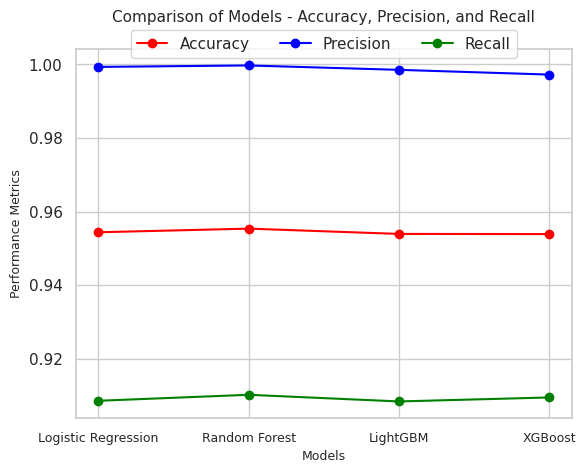

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define the predictions for each model
y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate the accuracy, precision, and recall for each model
accuracy_values = [accuracy_score(y_test, y_pred_logreg),
                   accuracy_score(y_test, y_pred_rf),
                   accuracy_score(y_test, y_pred_lgb),
                   accuracy_score(y_test, y_pred_xgb)]

precision_values = [precision_score(y_test, y_pred_logreg),
                    precision_score(y_test, y_pred_rf),
                    precision_score(y_test, y_pred_lgb),
                    precision_score(y_test, y_pred_xgb)]

recall_values = [recall_score(y_test, y_pred_logreg),
                 recall_score(y_test, y_pred_rf),
                 recall_score(y_test, y_pred_lgb),
                 recall_score(y_test, y_pred_xgb)]

# Set the models' names
model_names = ['Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost']

# Set the x-axis positions for the data points
x = np.arange(len(model_names))

# Create a line plot for accuracy
plt.plot(x, accuracy_values, marker='o', label='Accuracy', color='red')

# Create a line plot for precision
plt.plot(x, precision_values, marker='o', label='Precision', color='blue')

# Create a line plot for recall
plt.plot(x, recall_values, marker='o', label='Recall', color='green')

# Set labels and title
plt.xlabel('Models', fontsize=9)
plt.ylabel('Performance Metrics', fontsize=9)
plt.title('Comparison of Models - Accuracy, Precision, and Recall', fontsize=11, y=1.05)

# Set x-axis tick labels and rotate them for better visibility
plt.xticks(x, model_names, rotation=0, fontsize=9)

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=3)

# Show the plot
plt.show()


In [ ]:
print(df.columns)
print(df.shape)

Index(['Model', 'Accuracy', 'Precision', 'Recall', 'MSE'], dtype='object')
(5, 5)


# To Plot The accuracy

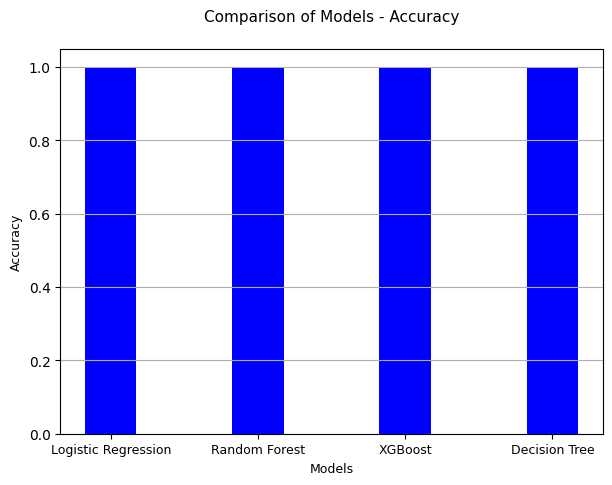